# Analyse logs from OpenSci-ref

First download the logs from https://huggingface.co/datasets/open-sci/open-sci-ref-0.01-logs/tree/main and extract them,

```bash
wget https://huggingface.co/datasets/open-sci/open-sci-ref-0.01-logs/resolve/main/logs.tar.gz
tar xvf logs.tar.gz
```

The files should be written under `leonardo_work/EUHPC_E03_068/...`.

Then run the notebook with

```bash
uv run jupyter-notebook
```

### Required in collab

If you run in collab, you would need to install ipywidgets:
```
%pip install -q ipywidgets
```

In [1]:
# checks that logs have been downloaded/extracted
!ls leonardo_work/

EUHPC_E03_068


In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import json
import pandas as pd
import numpy as np

In [3]:
from pathlib import Path
from parse_data import load_all_metrics
hp_dicts, slurm_dicts, df_metrics = load_all_metrics()

could not parse path jobid: /Users/salinasd/Documents/code/openeurollm/notebooks/logs-opensci-ref/leonardo_work/EUHPC_E03_068/jjitsev0/megatron_lm_reference/slurm_output/.ipynb_checkpoints/open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-NeoX_samples-50B_global_bs-2048_context-2048_schedule-WSD_lr-5e-3_warmup-1500_machine-LEONARDO_11095032-checkpoint.out
could not parse path jobid: /Users/salinasd/Documents/code/openeurollm/notebooks/logs-opensci-ref/leonardo_work/EUHPC_E03_068/jjitsev0/megatron_lm_reference/slurm_output/open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-NeoX_samples-300B_global_bs-2048_context-2048_schedule-WSD_lr-5e-3_warmup-30000_machine-LEONARDO_11627851_NODE_FAILURE.out
Found 64 models.


In [4]:
model_names = df_metrics["model_name"].unique().tolist()

In [8]:

def show_info_model_name(model_name, smooth: bool = False):    
    # 1) show hyperparameter
    # 2) show number of GPU, WC time, GPU hour
    # 3) show training loss
    df_model = df_metrics.loc[df_metrics["model_name"] == model_name, :].copy()
    hp_model = slurm_dicts[model_name]

    print(f"Model: {model_name}")

    print("Hyperparameter:")
    print(json.dumps(slurm_dicts[model_name], indent=4))
    print(f'Number of GPUs: {hp_model["NUM_GPUS"]}')
    
    print(f'Number of time-stamps: {len(df_model)}')
    print(f'Number of jobs: {len(df_model["jobid"].unique())}')
    runtime = df_model["elapsed_time_per_iteration_ms"].sum() / 1000 / 3600
    
    print(f"Iteration Wallclock time: {runtime:.2f} hours") 

    total_wctime = (df_model.timestamp.max() - df_model.timestamp.min()).seconds / 3600
    print(f"Total Wallclock time: {total_wctime:.2f} hours") 
    print(f'GPU Hours: {runtime * hp_model["NUM_GPUS"]:.2f} hours') 
    #print("Logs:")
    #paths = [str(x) for x in df_metrics["path"].unique()]
    #print("\n".join(paths))
    #print(sorted(df_model.columns))

    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    ax = axes

    if "SEQUENCE LENGTH" in hp_model:
        TOKENS_GLOBAL_BATCH_SIZE = hp_model["GLOBAL_BATCH_SIZE"] * hp_model["SEQUENCE LENGTH"]
        df_model["num-tokens"] = df_model.loc[:, "iteration"] * TOKENS_GLOBAL_BATCH_SIZE
        index="num-tokens"
    else:
        index="iteration"
    dd = df_model.pivot_table(index=index, values="lm_loss")

    if smooth:
        dd.ewm(span=3).mean().plot(ax=ax)
    else:
        dd.plot(ax=ax)
    ax.grid()
    ax.set_xlabel(index)
    ax.set_ylabel("Loss")
    ax.set_xscale("log")
    ax.set_yscale("log")

    plt.show()
    return 
interact(show_info_model_name, model_name=list(sorted(df_metrics.model_name.unique())), smooth=False)


interactive(children=(Dropdown(description='model_name', options=('open-sci-ref_model-0.13b_data-CommonCorpus_…

<function __main__.show_info_model_name(model_name, smooth: bool = False)>

In [6]:

rows = []
for model_name, hp in hp_dicts.items():
    row = hp
    row["model_name"] = model_name
    rows.append(row)
df_hp = pd.DataFrame(rows)
df_metrics_with_hps = pd.merge(df_metrics, df_hp, on="model_name")

In [8]:
#df_metrics_with_hps["num-tokens"] = df_metrics_with_hps["iteration"] * df_metrics_with_hps["seq_length"] * df_metrics_with_hps["global_batch_size_x"]

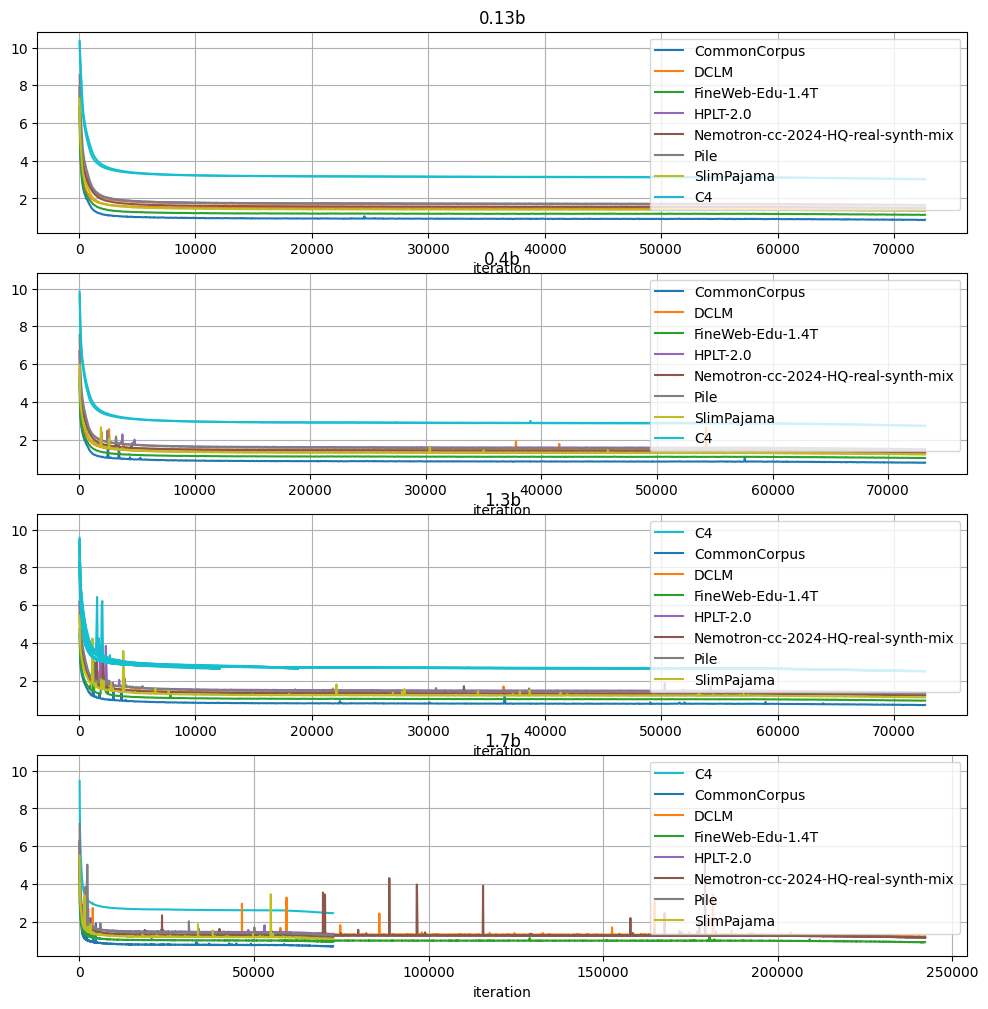

In [17]:
fig, axes = plt.subplots(
    4, 1, figsize=(12, 12),
#    sharex=True,
    sharey=True
)
axes = np.ravel(axes)
model_sizes = ["0.13b", "0.4b", "1.3b", "1.7b"]
color_map = None
for i, model_size in enumerate(model_sizes):
    ax = axes[i]
    # Create the pivot table
    dd = df_metrics_with_hps[df_metrics_with_hps["model_size"] == model_size].pivot_table(
        index="iteration", values="lm_loss", columns="model_name"
    )
    
    # Create color mapping
    filtered_df = df_metrics_with_hps[df_metrics_with_hps["model_size"] == model_size].copy()

    # why different order??
    filtered_df.sort_values(by=["dataset", "model_name"], inplace=True)
    model_to_dataset = filtered_df.groupby("model_name")["dataset"].first()
    datasets = model_to_dataset.unique()

    if color_map is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(datasets)))
        color_map = dict(zip(datasets, colors))
    
    # Plot with colors based on dataset
    ax = dd.plot(
        color=[color_map[model_to_dataset[col]] for col in dd.columns],
        legend=False,
        ax=ax,
        #ls="None",
        #marker=".",
    )
    ax.grid()
    
    # Create custom legend
    handles = [plt.Line2D([0], [0], color=color_map[dataset], label=dataset) 
              for dataset in datasets]
    ax.set_title(model_size)
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.legend(handles=handles)

In [55]:
from ipywidgets import interact, Dropdown, Checkbox
import ipywidgets as widgets

datasets = df_metrics_with_hps["dataset"].unique().tolist()
model_sizes = ["0.13b", "0.4b", "1.3b", "1.7b"]

@interact(
    dataset=Dropdown(options=datasets, description='Dataset:'),
    log_x=Checkbox(value=False, description='Log X'),
    log_y=Checkbox(value=False, description='Log Y')
)
def plot_dataset(dataset, log_x, log_y):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
    
    for j, model_size in enumerate(model_sizes):
        ax = axes[j]
        
        # Filter for this dataset and model size
        mask = (df_metrics_with_hps["dataset"] == dataset) & (df_metrics_with_hps["model_size"] == model_size)
        filtered_df = df_metrics_with_hps[mask]
        
        if len(filtered_df) > 0:
            # Create the pivot table
            dd = filtered_df.pivot_table(
                index="iteration", values="lm_loss", columns="model_name"
            )
            
            # Plot without specifying color (each config gets different color)
            dd.plot(
                legend=False,
                ax=ax,
            )
        
        ax.grid()
        ax.set_title(model_size)
        
        if log_x:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')
    
    plt.suptitle(dataset, fontsize=14)
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Dataset:', options=('DCLM', 'FineWeb-Edu-1.4T', 'C4', 'HPLT-2.0', …

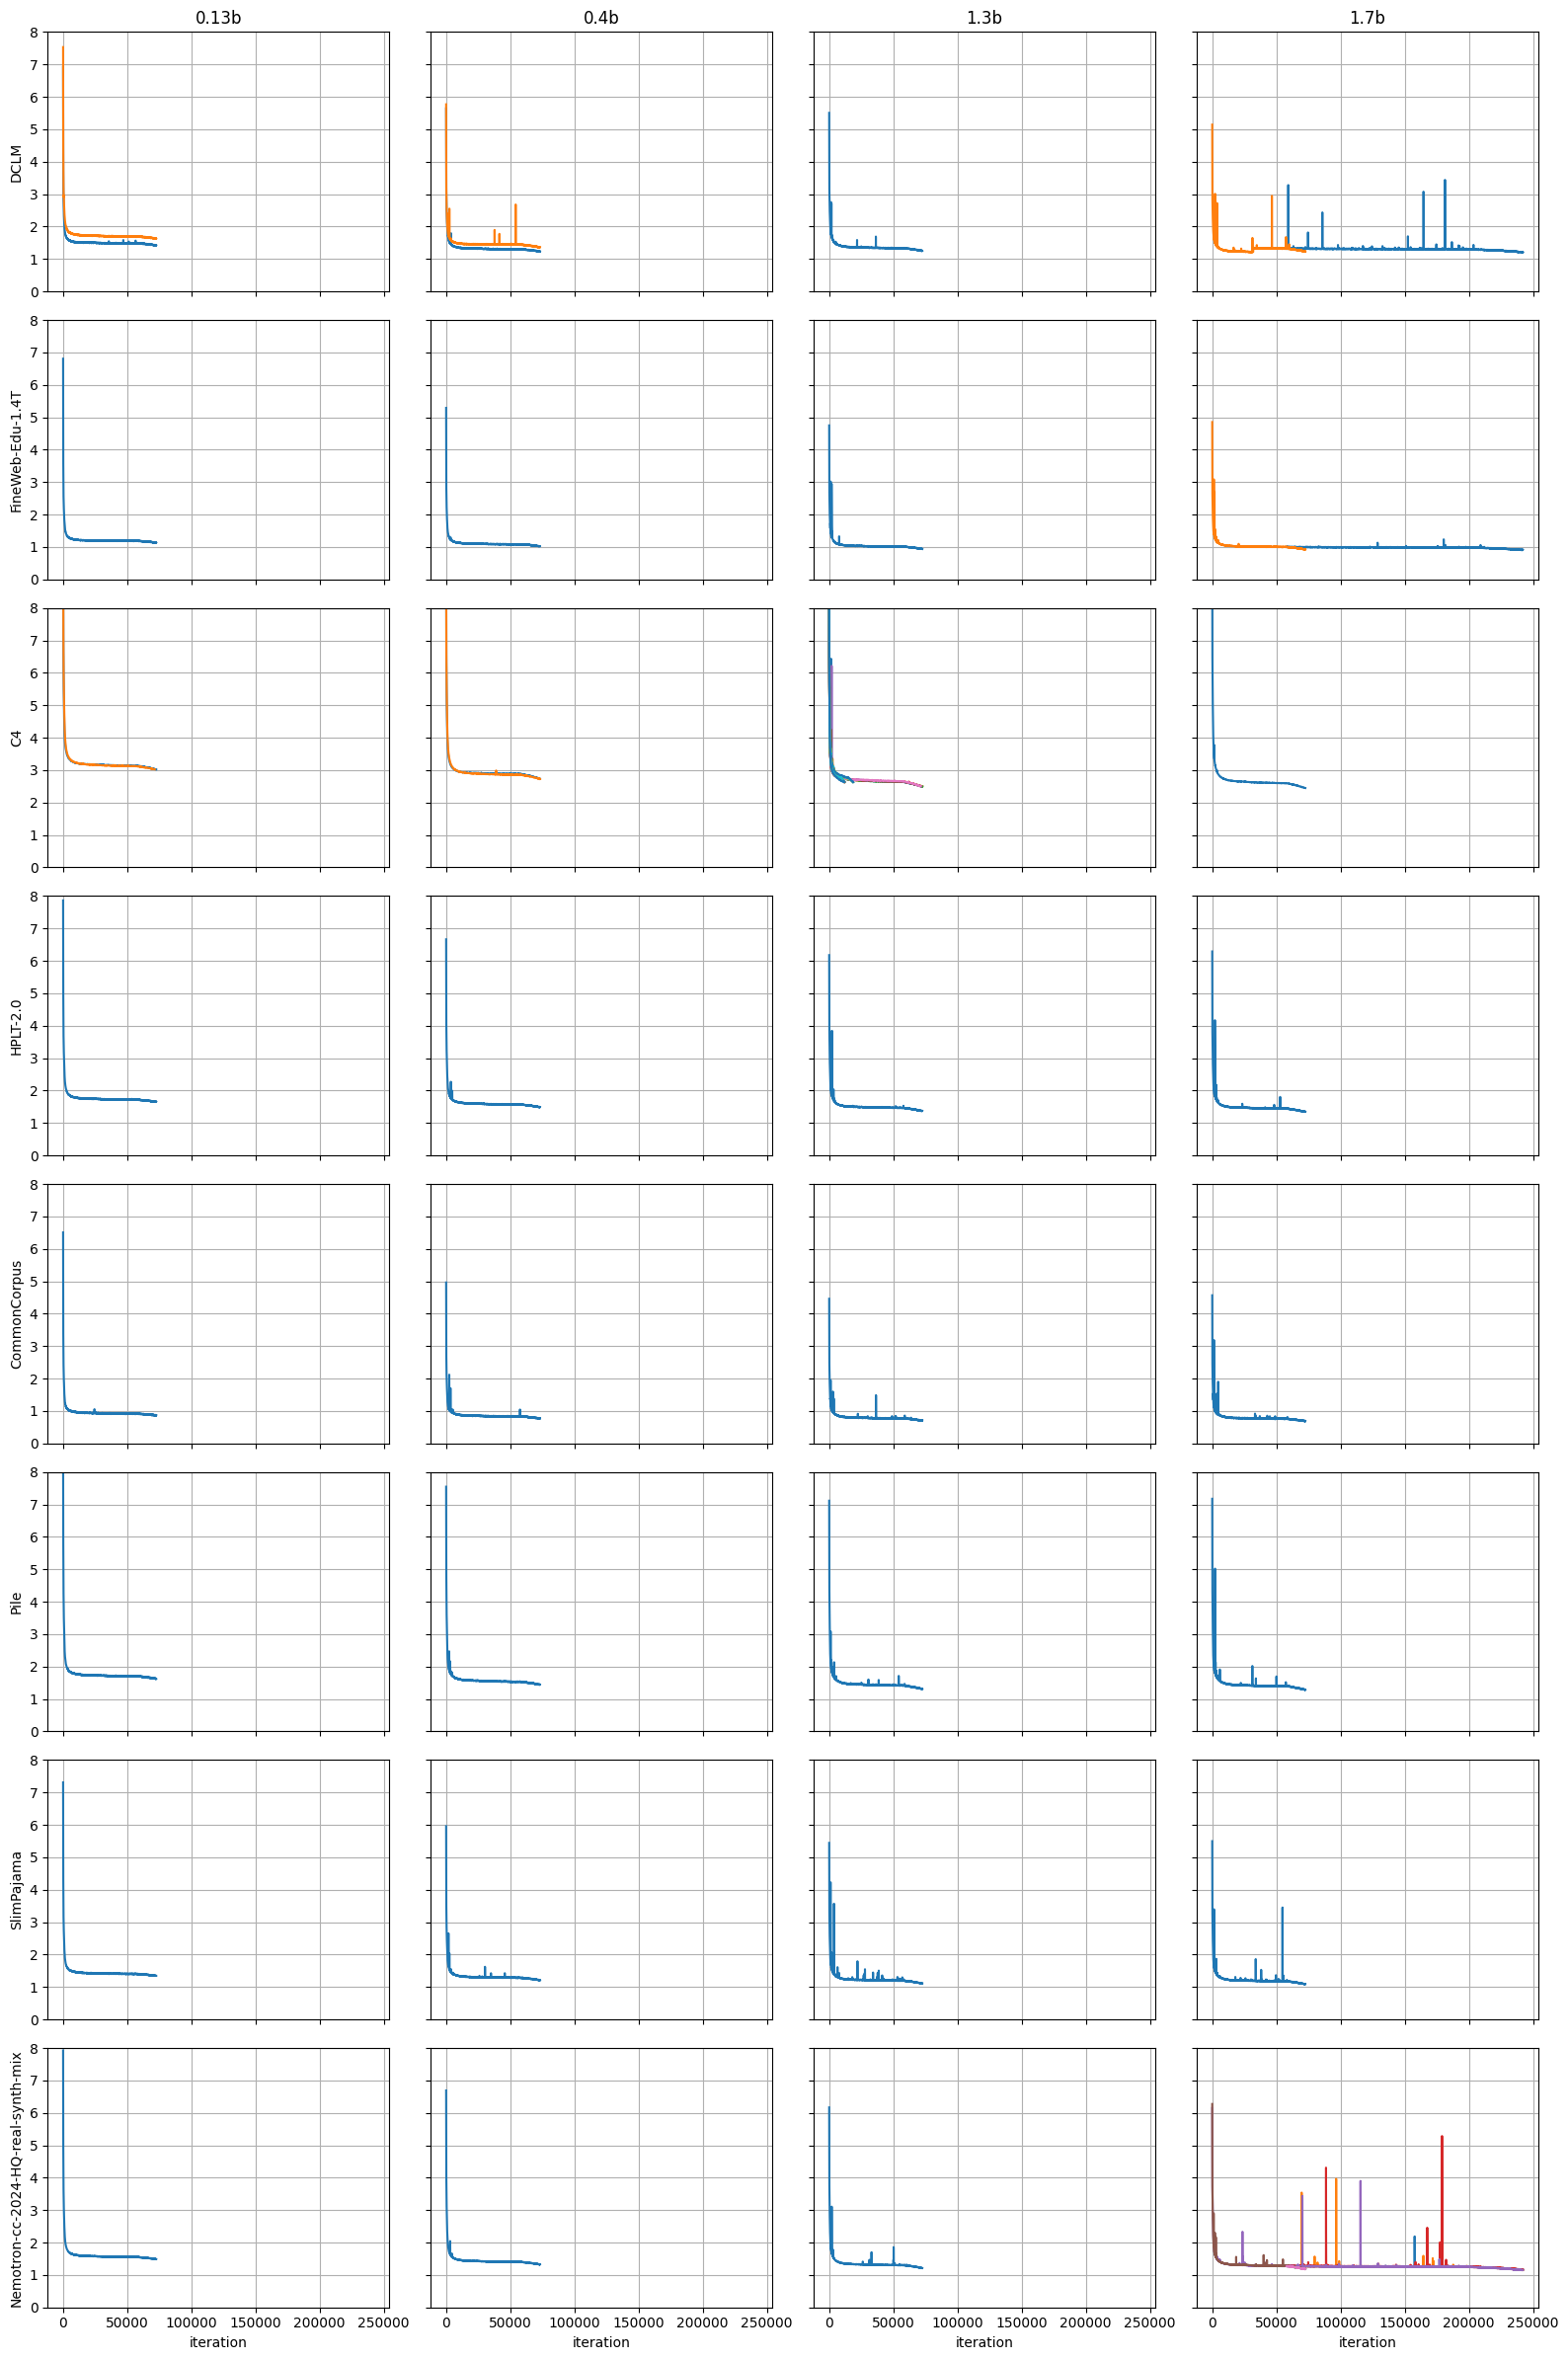

In [22]:
# Get unique datasets and model sizes
datasets = df_metrics_with_hps["dataset"].unique()
model_sizes = ["0.13b", "0.4b", "1.3b", "1.7b"]

fig, axes = plt.subplots(
    len(datasets), len(model_sizes), figsize=(16, 3 * len(datasets)),
    sharey=True,
    sharex=True,
)

for i, dataset in enumerate(datasets):
    for j, model_size in enumerate(model_sizes):
        ax = axes[i, j]
        
        # Filter for this dataset and model size
        mask = (df_metrics_with_hps["dataset"] == dataset) & (df_metrics_with_hps["model_size"] == model_size)
        filtered_df = df_metrics_with_hps[mask]
        
        if len(filtered_df) > 0:
            # Create the pivot table
            dd = filtered_df.pivot_table(
                index="iteration", values="lm_loss", columns="model_name"
            )
            
            # Plot without specifying color (each config gets different color)
            dd.plot(
                legend=False,
                ax=ax,
            )
        
        ax.grid()
        
        # Set titles
        if i == 0:
            ax.set_title(model_size)
        if j == 0:
            ax.set_ylabel(dataset)
        #ax.set_xlim([5000, None])
        ax.set_ylim([0, 8])
plt.tight_layout()
plt.show()

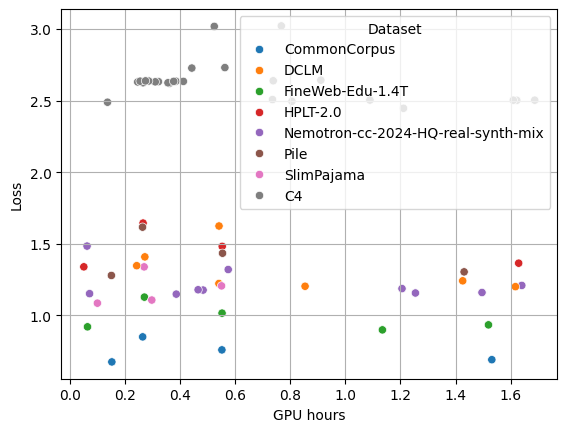

In [11]:
runtimes = (df_metrics.groupby("model_name").max()["timestamp"] - df_metrics.groupby("model_name").min()["timestamp"]).apply(lambda x: x.seconds / 3600)
num_gpus = pd.Series({model_name: slurm_dicts[model_name]["NUM_GPUS"] for model_name in runtimes.index})
gpu_runtimes = runtimes * num_gpus

lm_loss = df_metrics.groupby("model_name").min()["lm_loss"]

dd = pd.DataFrame({
    "GPU hours": gpu_runtimes / 3600,
    "Loss": lm_loss,
    "Dataset": pd.Series({model_name: hp_dicts[model_name]["dataset"] for model_name in runtimes.index}),
    "Size": pd.Series({model_name: hp_dicts[model_name]["model_size"] for model_name in runtimes.index}),    
})
ax = sns.scatterplot(
    dd,
    x="GPU hours",
    y="Loss",
    hue="Dataset",
    color="Size",
)
ax.grid()

In [12]:
df_metrics_with_hps.drop_duplicates(["model_name", "model_size"]).groupby("model_size").count()

,node_id,timestamp,iteration,total_iterations,consumed_samples,elapsed_time_per_iteration_ms,throughput_per_gpu_tflops,learning_rate,global_batch_size_x,lm_loss,...,train_iters,lr_decay_style,lr_warmup_iters,lr_decay_iters,lr,min_lr,tied_embedding,original_log_dir_name,dataset,tokenizer
model_size,,,,,,,,,,,,,,,,,,,,,
0.13b,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
0.4b,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
1.3b,28,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28
1.7b,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16


In [15]:
df_metrics_with_hps["num-tokens"] = df_metrics_with_hps["iteration"] * df_metrics_with_hps["seq_length"] * df_metrics_with_hps["global_batch_size_y"]

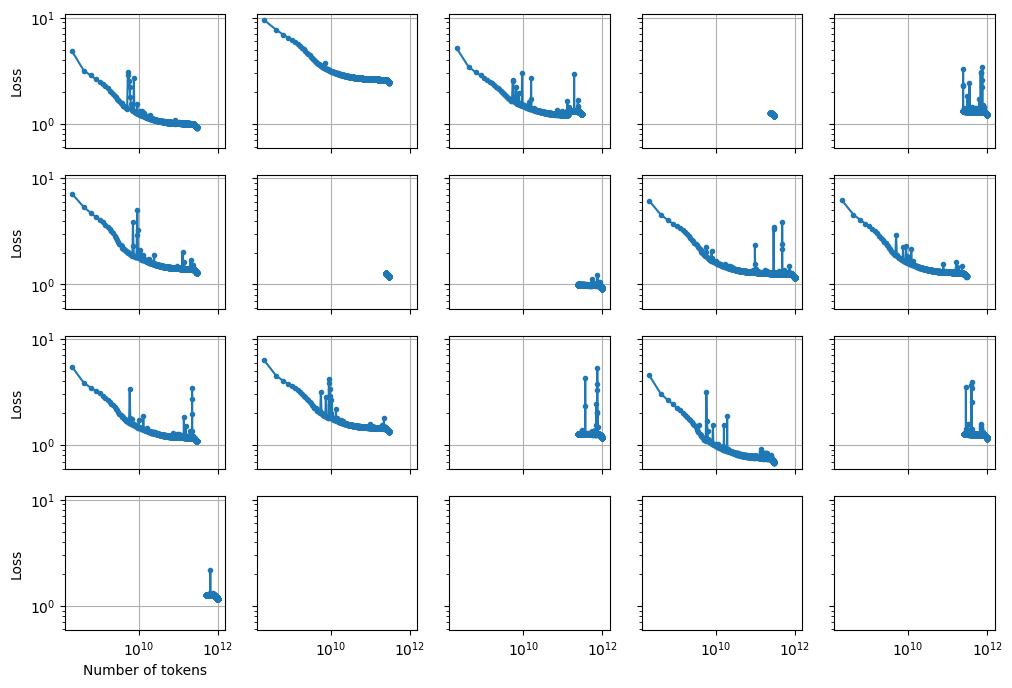

In [16]:
#model_size = "0.13b"
model_size = "1.7b"
#model_size = "1.3b"
df_sub = df_metrics_with_hps[df_metrics_with_hps.model_size == model_size].copy()
models = df_sub.model_name.unique()

plot_per_col = 5 
ncols = 5
nrows = int(np.ceil(len(models) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2 * nrows), sharey=True, sharex=True)

axes = np.ravel(axes)

for i, model in enumerate(models):
    ax = axes[i]
    df_plot = df_sub[df_sub.model_name == model].pivot_table(index="num-tokens", values="lm_loss")
    df_plot.plot(ax=ax, marker=".", legend=None)
    ax.grid()
    ax.set_xlabel("Number of tokens")
    ax.set_ylabel("Loss")
    ax.set_xscale("log")
    ax.set_yscale("log")


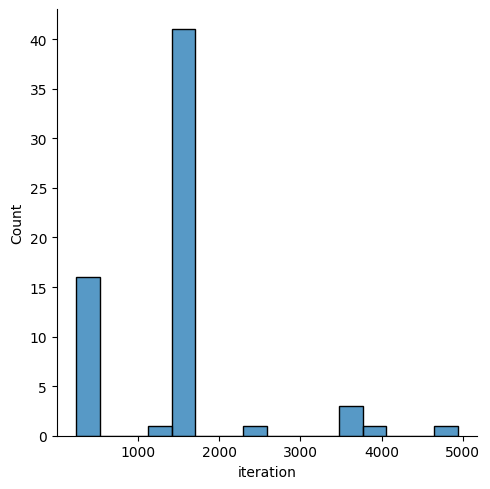

In [53]:
sns.displot(df_metrics.groupby("model_name").count()["iteration"])